In [1]:
import time
import matplotlib.pyplot as plt
from scipy import linalg
import sympy as sym
import numpy as np
import ae353_spacecraft
import importlib
importlib.reload(ae353_spacecraft)

pybullet build time: Sep  3 2021 23:59:09


<module 'ae353_spacecraft' from '/home/jefferyz/Documents/ISS_Learning_Controls/controls-demo/ae353_spacecraft.py'>

## Dynamic model

# Specify the physical parameters:
## mb: mass of body
## Jxb, Jyb, Jzb are the inertia values for the body 
## mw: mass of reaction wheels 
## Jxw, Jyw, Jzw are the inertia values for the reaction wheels
## lw is a dimention parameter for the wheel itself


In [2]:
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the equations of motion:

In [3]:
# roll, pitch, yaw angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# parameters
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)
print(T)

Matrix([[-11*sqrt(2)*tau_1/20 + 11*sqrt(2)*tau_2/20], [-11*sqrt(2)*tau_3/20 + 11*sqrt(2)*tau_4/20], [-11*sqrt(2)*tau_1/20 - 11*sqrt(2)*tau_2/20 - 11*sqrt(2)*tau_3/20 - 11*sqrt(2)*tau_4/20]])


The equations of motion have this form:

$$\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\phi, \theta, \psi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

In [4]:
f

Matrix([
[                        (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                                     w_x*sin(psi) + w_y*cos(psi)],
[        -w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

# Making "f" an executable function
## Lambdify is setup in a way that values can be easily substituted in for the variables

In [5]:
f_num = sym.lambdify((phi,theta,psi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4),f)

# Defining a set of Equilibrium Values for the states so that f() == 0
## These values are specifically chosen so that the control system may converge to those desired values. And in this case, we want the spacecraft to maintain its attitude given external disturbances. 

In [6]:
phi_e = 0
theta_e = 0
psi_e = 0
wx_e = 0
wy_e = 0
wz_e = 0
tau1_e = 0
tau2_e = 0
tau3_e = 0
tau4_e = 0

## 1) Making a function that subsitutes equilibrium values into the equations of motion 
## 2) Verify the equilibrium values make f() == 0
## 3) Print out the f matrix and make sure it returns a 6 by 1 column matrix

In [7]:
feq = f_num(phi_e,theta_e,psi_e,wx_e,wy_e,wz_e,tau1_e,tau2_e,tau3_e,tau4_e)
feq

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.]])

# Linearizing the equations of motion 

## x: state vector (variables we are interested in)
## $\dot{x}$: time rate change of state
## u: inputs vector (actuators in the system that we control)
## A matrix: Relates the states to the time rate change of state
## B matrix: Relates the inputs to the time rate change of state

## 1) $\dot{x}$ = Ax + Bu. To get the A matrix, we apply a Jacobian function, which takes the partial derivatives of all of the equations of motion with respect to each state variable. In this case, we call the Jacobian on our symbolic function "f".


## 2) Only ($\phi$, $\theta$, $\psi$, $w_x$, $w_y$, $w_z$) will be accounted for in the A matrix since the other four ($\tau_1$, $\tau_2$, $\tau_3$, and $\tau_4$) are the inputs "u". So those are accounted for in the B matrix.


In [8]:
states = [phi,theta, psi, w_x, w_y, w_z]
A_sym = f.jacobian(states)

inputs = [tau_1, tau_2, tau_3, tau_4]
B_sym = f.jacobian(inputs)

## We want to linearize about our equilibirium values, so we need to sub in the equilibrium values into the symbolic A and B matrices.

In [9]:
A_num = sym.lambdify(states,A_sym)
B_num = sym.lambdify(inputs,B_sym)

A = A_num(phi_e,theta_e,psi_e,wx_e,wy_e,wz_e)
B = B_num(tau1_e, tau2_e, tau3_e, tau4_e)

# Checking for controllability
## $\dot{x}$ = Ax + Bu where u = -Kx
## K is a constant matrix that we choose that tells us what our inputs should be, given our state.

## First, we create the controllability matrix, as shown below

## We can check if the controllability matrix is of full rank, meaning that the system is controllable

In [10]:

#* Number of states
n = len(B)

#* Initialize the Controllability Matrix
W = B

#* Create the Controllability Matrix
for i in range(1,n):
    new_mat = np.linalg.matrix_power(A, i) @ B
    W = np.block([W,new_mat])

#* Make sure that the rank of the matrix is equal to the number of states
if (np.linalg.matrix_rank(W) == n):
    print("FULL RANK")
else:
    print("RANK DEFICIENT") 

FULL RANK


# LQR Design (Linear Quadratic Regulator)

## LQR is useful for optimal control - choosing a K matrix to stabilize the system without too much effort

## Q and R matrices need to be implemented where Q can be seen as a "penalty" matrix that tells us how bad the penalty is if the states are not at where we want them to be. In other words, by looking at the diagonals of this matrix, we could assign values cooresponding to the different states we are interested in. We start with an identity matrix I, with 1s in the diagonal. If we are interested in making the state "theta" or "theta dot" go to our desired state faster, we could put 10 or 100 in those slots. 

## The R matrix tells us how bad the penalty is for using our actuators.


In [11]:
## Designing a Q matrix 
Q_diag = np.array([1,1,1,10,10,10]) #roll, pitch, yaw, wx, wy, wz
Q = np.diag(Q_diag)

## Designing a R matrix
R_diag = np.array([0.1,0.1,0.1,0.1]) #tau1, tau2, tau3, tau4
R = np.diag(R_diag)

#* Making a LQR function that outputs k
#* We solve the Ricatti equation for optimal controller gains
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    return K
K = lqr(A,B,Q,R)

##* testing to see if the A - BK has all negative eigenvalues 
F = A - B@K
eig = np.linalg.eigvals(F)

print(eig.real < 0)


[ True  True  True  True  True  True]


## Sensor model

Symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star:

In [12]:
alpha, delta = sym.symbols('alpha, delta')

Specify the physical parameters:

In [13]:
# Scope radius
r = 0.8 / 2.1

Derive the sensor model:

In [14]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rx * Ry * Rz

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True) 

The sensor model has this form for each star:

$$\zeta = g(\phi, \theta, \psi, \alpha, \delta)$$

Here is the function $g$:

In [15]:
g

Matrix([
[21*((sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*sin(delta) - (sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*sin(alpha)*cos(delta) - sin(psi)*cos(alpha)*cos(delta)*cos(theta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))],
[                                                                      21*(-sin(alpha)*sin(phi)*cos(delta)*cos(theta) + sin(delta)*cos(phi)*cos(theta) + sin(theta)*cos(alpha)*cos(delta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))]])

## g is a function of the $\alpha$,$\delta$, and other state variables that give us the pixel positions for each star

In [16]:
# making G a combination of multiple stars, in this case, we are doing 3 stars
alpha1 = 0
delta1 = 0
alpha2 = 0.15
delta2 = 0
alpha3 = 0
delta3 = 0.15

G = np.block([[g.subs([(alpha,alpha1),(delta,delta1)])],[g.subs([(alpha,alpha2),(delta,delta2)])],[g.subs([(alpha,alpha3),(delta,delta3)])]])
G = sym.Matrix(G) #turning an array into a symbolic matrix expression
G


Matrix([
[                                                                                                                                                                                                                                            -21*sin(psi)/(8*cos(psi))],
[                                                                                                                                                                                                                                21*sin(theta)/(8*cos(psi)*cos(theta))],
[21*(-0.149438132473599*sin(phi)*sin(psi)*sin(theta) - 0.988771077936042*sin(psi)*cos(theta) + 0.149438132473599*cos(phi)*cos(psi))/(8*(0.149438132473599*sin(phi)*sin(theta)*cos(psi) + 0.149438132473599*sin(psi)*cos(phi) + 0.988771077936042*cos(psi)*cos(theta)))],
[                                                        21*(-0.149438132473599*sin(phi)*cos(theta) + 0.988771077936042*sin(theta))/(8*(0.149438132473599*sin(phi)*sin(theta)*cos(psi) + 0.149438132

## Next step is to find the equilibrium state for G. Same thing as before, we need to use Lambdify so that we could sub in the equilibrium values of phi, theta, and psi


In [17]:
G_num = sym.lambdify((phi, theta, psi), G)
Geq = G_num(phi_e, theta_e, psi_e)
Geq.tolist()

[[-0.0], [0.0], [0.3967299474030241], [0.0], [0.0], [0.3967299474030241]]

## Now, we linearize the system by taking the Jacobian of the equations of motion for our outputs with respect to our states

In [18]:
C_num = sym.lambdify((phi, theta, psi), G.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C = C_num(phi_e,theta_e,psi_e)
C

array([[ 0.        ,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -2.68495987,  0.        ,  0.        ,
         0.        ],
       [-0.39672995,  2.625     , -0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.39672995,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [-0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ]])

## Now, we can check the observability of the system.

## Observability is the ability of a system to estimate any state from a history of sensor measurements
## It's useful to have an observer when we have states that we cannot directly measure.

In [19]:
Wo = C

for i in range(1,n):
    row = C @ np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[row]])

rank = np.linalg.matrix_rank(Wo)
print(rank)

6


# Optimal Observer Design

## We can use LQR to find an optimal observer

In [20]:
Qo = np.diag(np.ones(2*3))
# 2 outputs per star -> 6 total output values

# Low penalty to the actuators
Ro = 0.05 * np.diag([1.,1.,1.,1.,1.,1.])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

#The real part of all eigenvalues should be negative
H = A - L@C
eig_o = linalg.eigvals(H)
print(eig_o.real < 0)


[ True  True  True  True  True  True]


# Simulation with Controller

In [21]:
class RobotController:
    def __init__(self, A, B, C, K, L, Geq):
        self.dt = 0.01
        self.K = K
        self.L = L
        self.A = A
        self.C = C
        self.B = B
        self.Geq = Geq 
        # All the equilibrium values were chosen to be 0, so they are not defined here
        self.reset()
    
    def reset(self):
        self.xhat = np.zeros((6, 1))
    
    def run(self, p, v):
        z = np.array([p]).T
        y = np.array(z - self.Geq)
        u = -self.K @ self.xhat
        tau = np.array([u[0,0], u[1,0], u[2,0], u[3,0]])
        xhatold = self.xhat
        for i in range(self.xhat.shape[0]):
            if np.isnan(self.xhat[i,0]):
                self.xhat[i,0] = xhatold[i,0]
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C@self.xhat  - y))
        return tau

controller = RobotController(A, B, C, K, L, Geq)

argv[0]=--background_color_red=0
argv[1]=--background_color_blue=0
argv[2]=--background_color_green=0
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=0
argv[2] = --background_color_blue=0
argv[3] = --background_color_green=0
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel Open Source Technology Center
GL_RENDERER=Mesa DRI Intel(R) Iris(R) Graphics 5100 (HSW GT3)
GL_VERSION=4.5 (Core Profile) Mesa 20.0.8
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 20.0.8
Vendor = Intel Open Source Technology Center
Renderer = Mesa DRI Intel(R) Iris(R) Graphics 5100 (HSW GT3)
b3Printf: Selected demo: Physics Server
startThre

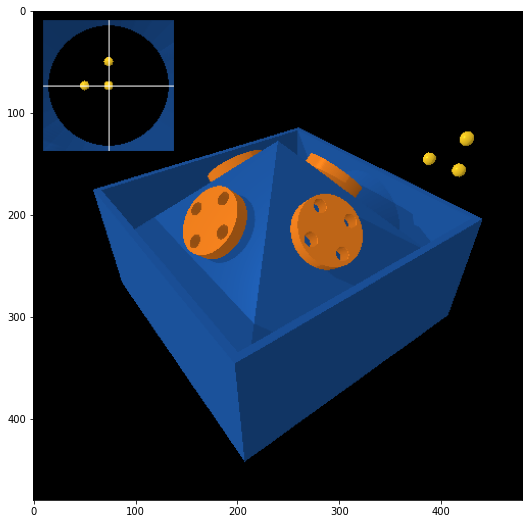

In [22]:
robot = ae353_spacecraft.RobotSimulator(display=True, 
shootingstar = True, 
stars = np.array([[alpha1,delta1],[alpha2,delta2],[alpha3,delta3]]), 
scope_noise=0.1)

# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = robot.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

plt.imsave('my_snapshot.png', rgba)


# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time =  30
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

p = np.zeros(2 * 3) #CHANGE this when changing no. of stars
v = np.zeros(4)
# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    pold = p
    vold = v
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    # Ensuring we don't get nan values
    for i in range(p.shape[0]):
        if np.isnan(p[i]):
            p[i] = pold[i]
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
print(f'elapsed time: {time.time() - start_time:.1f}')



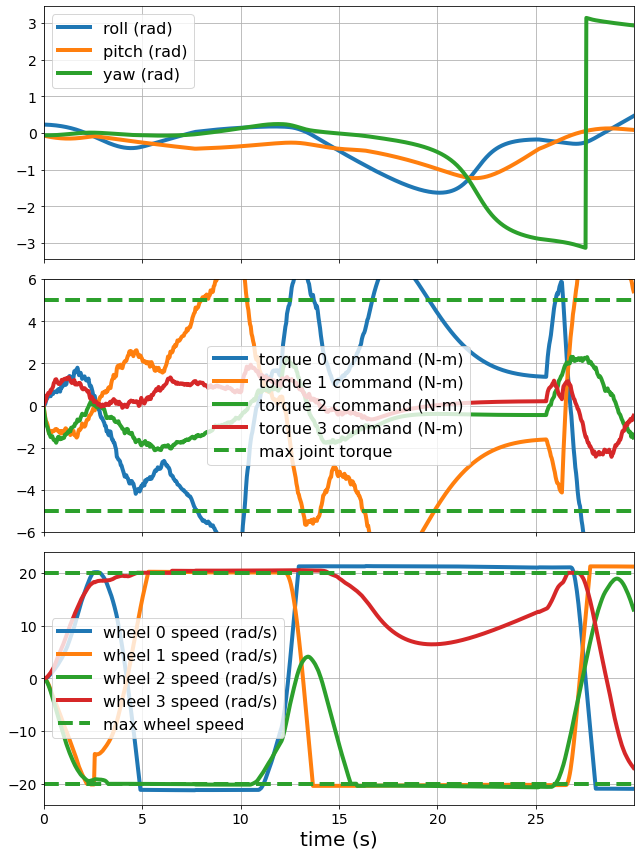

In [23]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_rpy, ax_tau, ax_v) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Wheel torques
for i in range(4):
    ax_tau.plot(data['t'], data['tau'][i, :], label=f'torque {i} command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Wheel speeds
for i in range(4):
    ax_v.plot(data['t'], data['v'][i, :], label=f'wheel {i} speed (rad/s)', linewidth=4)
ax_v.plot(data['t'], np.ones_like(data['t']) * robot.v_max, '--', label='max wheel speed', linewidth=4, color='C2')
ax_v.plot(data['t'], -np.ones_like(data['t']) * robot.v_max, '--', linewidth=4, color='C2')
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-1.2 * robot.v_max, 1.2 * robot.v_max)

# Set shared x-axis properties
ax_v.set_xlabel('time (s)', fontsize=20)
ax_v.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()